In [1]:
#Import all the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys 
import os
import pickle
import tensorflow as tf
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPool2D
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import Sequential
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

In [2]:
#Set all the Constants
batchSize = 32
imageSize = 256
channels=3
epoch = 70 

In [3]:
#Import data into tensorflow dataset object()
imageDataset = tf.keras.preprocessing.image_dataset_from_directory(
    "skinDisease Datasets", seed=123, shuffle=True, image_size=(imageSize,imageSize), batch_size=batchSize
)

Found 4518 files belonging to 4 classes.


In [4]:
#Check for dataset classes
classNames = imageDataset.class_names
classNames

['Acne', 'Eczema', 'Melanoma Skin Cancer Nevi and Moles', 'Psoriasis']

In [5]:
#Check for dataset bacth size
for image_batch,label_batch in imageDataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


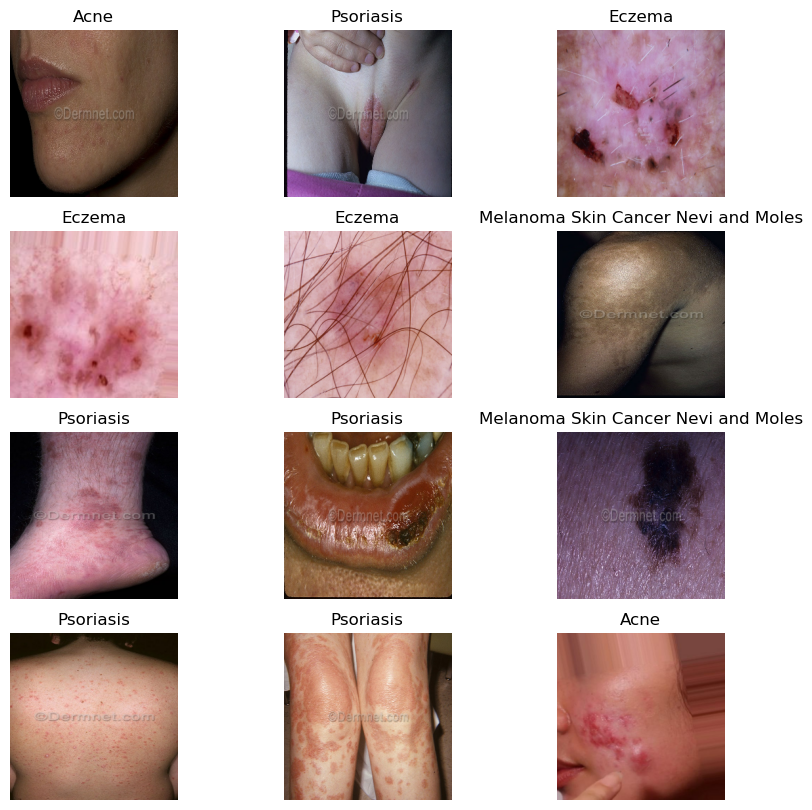

In [6]:
#VGet some images from the dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in imageDataset.take(1):
    for i in range(12):
        shuffle = True
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classNames[labels_batch[i]])
        plt.axis("off")

In [7]:
#Function to split Dataset
#80% taken as training data
#10% taken as validation data
#10% taken as testing data

In [8]:
def get_dataset_partitions_tf(ds, trainSplit=0.8, valSplit=0.1, testSplit=0.1, shuffle=True, shuffle_size=10000):
    assert (trainSplit + testSplit + valSplit) == 1
    
    datasetSize = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    trainSize = int(trainSplit * datasetSize)
    validationSize = int(valSplit * datasetSize)
    
    trainDataset = ds.take(trainSize)    
    validationDataset = ds.skip(trainSize).take(validationSize)
    testDataset = ds.skip(trainSize).skip(validationSize)
    
    return trainDataset, validationDataset, testDataset

In [9]:
trainDataset, validationDataset, testDataset = get_dataset_partitions_tf(imageDataset)

In [10]:
#Cache, shuffle and Prefetch the Dataset
trainDataset = trainDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validationDataset = validationDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset = testDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
#Building the model
#Creating a layer for resizing and normalization

In [12]:
#Data Pre-processing
resize_and_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(imageSize, imageSize),
  layers.experimental.preprocessing.Rescaling(1./255),])

In [13]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), 
                                         layers.experimental.preprocessing.RandomRotation(0.2),])

In [14]:
#Applying Data Augmentation to Train Dataset
trainDataset = trainDataset.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
#CNN model archiecture using sequential class
input_shape = (batchSize, imageSize, imageSize, channels)
classVal = 4

model = models.Sequential([resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
                           
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),                    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
                           
    layers.Flatten(),          
    layers.Dense(64, activation='relu'),
    layers.Dense(classVal, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [17]:
#Compiling the Model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [18]:
history = model.fit(trainDataset, batch_size=batchSize, validation_data=validationDataset, verbose=1, epochs=epoch,)

Epoch 1/70
113/113 [==============================] - 144s 1s/step - loss: 1.1758 - accuracy: 0.4298 - val_loss: 1.0943 - val_accuracy: 0.4799
Epoch 2/70
113/113 [==============================] - 130s 1s/step - loss: 1.0316 - accuracy: 0.5028 - val_loss: 1.0499 - val_accuracy: 0.4710
Epoch 3/70
113/113 [==============================] - 126s 1s/step - loss: 0.9026 - accuracy: 0.6020 - val_loss: 0.8812 - val_accuracy: 0.6406
Epoch 4/70
113/113 [==============================] - 147s 1s/step - loss: 0.8527 - accuracy: 0.6253 - val_loss: 0.8628 - val_accuracy: 0.6384
Epoch 5/70
113/113 [==============================] - 142s 1s/step - loss: 0.8087 - accuracy: 0.6571 - val_loss: 0.7887 - val_accuracy: 0.6607
Epoch 6/70
113/113 [==============================] - 146s 1s/step - loss: 0.7963 - accuracy: 0.6504 - val_loss: 0.8245 - val_accuracy: 0.6562
Epoch 7/70
113/113 [==============================] - 135s 1s/step - loss: 0.7558 - accuracy: 0.6712 - val_loss: 0.7859 - val_accuracy: 0.6741

Epoch 58/70
113/113 [==============================] - 108s 952ms/step - loss: 0.3430 - accuracy: 0.8642 - val_loss: 0.3704 - val_accuracy: 0.8371
Epoch 59/70
113/113 [==============================] - 107s 943ms/step - loss: 0.3370 - accuracy: 0.8714 - val_loss: 0.3753 - val_accuracy: 0.8527
Epoch 60/70
113/113 [==============================] - 114s 1s/step - loss: 0.3210 - accuracy: 0.8639 - val_loss: 0.3549 - val_accuracy: 0.8638
Epoch 61/70
113/113 [==============================] - 116s 1s/step - loss: 0.3296 - accuracy: 0.8703 - val_loss: 0.3586 - val_accuracy: 0.8438
Epoch 62/70
113/113 [==============================] - 116s 1s/step - loss: 0.3301 - accuracy: 0.8662 - val_loss: 0.3362 - val_accuracy: 0.8594
Epoch 63/70
113/113 [==============================] - 111s 976ms/step - loss: 0.3278 - accuracy: 0.8767 - val_loss: 0.3217 - val_accuracy: 0.8705
Epoch 64/70
113/113 [==============================] - 110s 970ms/step - loss: 0.3335 - accuracy: 0.8695 - val_loss: 0.3783 - v

In [19]:
scores = model.evaluate(testDataset)

15/15 [==============================] - 29s 419ms/step - loss: 0.4388 - accuracy: 0.8125


In [20]:
scores

[0.4387551546096802, 0.8125]

In [21]:
print("Model accuracy")
scores = model.evaluate(testDataset)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

Model accuracy
15/15 [==============================] - 6s 408ms/step - loss: 0.4388 - accuracy: 0.8125
Test Accuracy: 81.25%


In [22]:
len(history.history['loss'])

70

In [23]:
history.history['loss'][:5]

[1.1757967472076416,
 1.0316202640533447,
 0.9025657176971436,
 0.8527462482452393,
 0.8086507320404053]

In [24]:
accuracy = history.history['accuracy']
validationAccuracy = history.history['val_accuracy']

loss = history.history['loss']
validationLoss = history.history['val_loss']

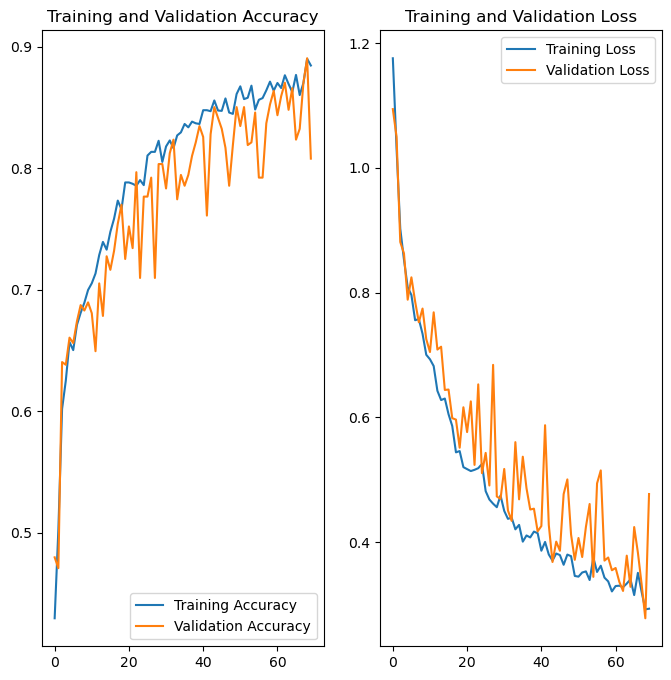

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), accuracy, label='Training Accuracy')
plt.plot(range(epoch), validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), loss, label='Training Loss')
plt.plot(range(epoch), validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
Actual disease: Acne
1/1 [==============================] - 1s 1s/step
Predicted disease: Acne


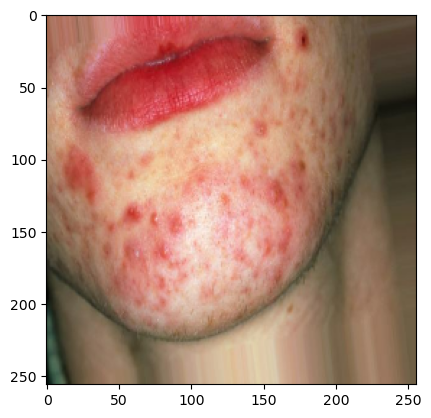

In [26]:
#Run test on a sample image
for images_batch, labels_batch in testDataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual disease:",classNames[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted disease:",classNames[np.argmax(batch_prediction[0])])

In [27]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classNames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 78ms/step


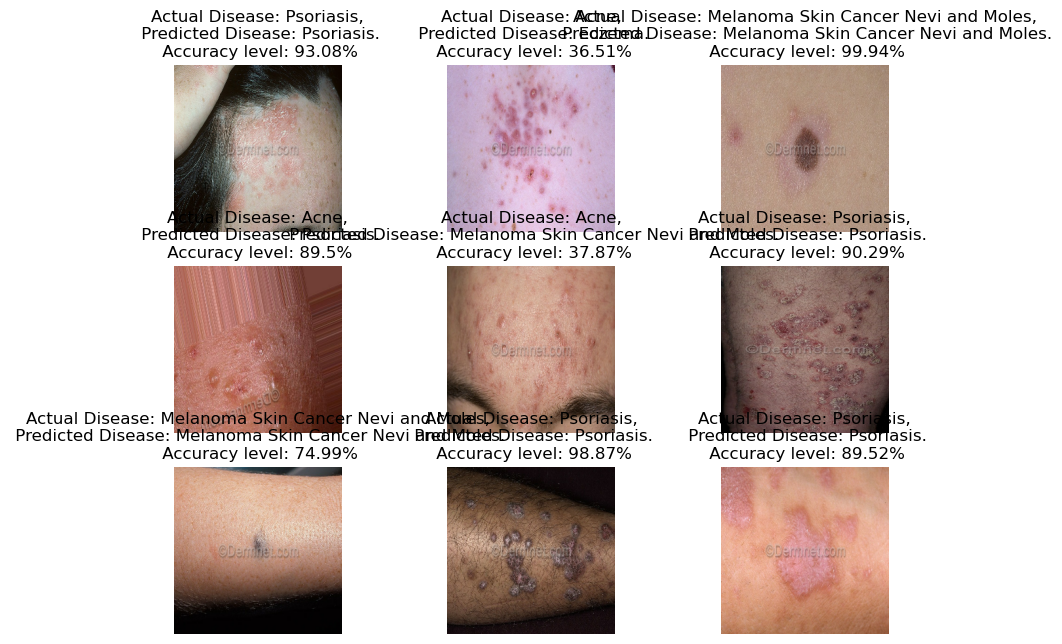

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in testDataset.take(1):
    for i in range(9):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classNames[labels[i]] 
        plt.title(f"Actual Disease: {actual_class},\n Predicted Disease: {predicted_class}.\n Accuracy level: {confidence}%")
        plt.axis("off")

In [29]:
model_version=max([int(i) for i in os.listdir("../skinDiseaseDetection/models") + [0]])
model.save(f"../skinDiseaseDetection/models/{model_version}")

INFO:tensorflow:Assets written to: ../skinDiseaseDetection/models/2\assets


INFO:tensorflow:Assets written to: ../skinDiseaseDetection/models/2\assets


In [30]:
model.save("../model.h5")

In [31]:
filename = "CNN_model.pkl"
pickle.dump(model, open(filename,'wb')) 

INFO:tensorflow:Assets written to: ram://d076ec09-a365-491b-bb14-4b285d99c9fa/assets


INFO:tensorflow:Assets written to: ram://d076ec09-a365-491b-bb14-4b285d99c9fa/assets


In [32]:
# loaded_model = pickle.load(open(filename, 'rb'))
# loaded_model.predict(trainDataset)